In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


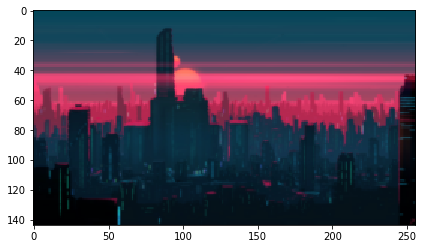

In [8]:
from skimage import io
from skimage.transform import rescale

# read our testing image in
tst_image = io.imread('./test_images/4.jpg')

# downsize the image
tst_image = rescale(tst_image, 0.1, anti_aliasing=True)
io.imshow(tst_image)

In [9]:
from sklearn.cluster import DBSCAN

def results_to_df(x_dat, clusters):
    concatenated = []
    for pixel, cluster in zip(x_dat, clusters):
        pixel = list(pixel)
        pixel.append(cluster)
        concatenated.append(pixel)
    result_df = pd.DataFrame(concatenated)
    result_df.columns = ['r', 'g', 'b', 'cluster']
    return result_df

def cluster_image_colours(input_img, cluster_model=DBSCAN, *model_args, **model_kwargs):
    # get the number of pixels using the shape of the image
    x_len = input_img.shape[0]
    y_len = input_img.shape[1]
    num_pixels = x_len * y_len

    # reshape to a 2d image
    x_dat = input_img.reshape(num_pixels, 3)

    # train/predict with input model
    model = cluster_model(*model_args, **model_kwargs)
    clusters = model.fit_predict(x_dat)

    # create a df with cluster as a label
    labelled_df = results_to_df(x_dat, clusters)

    # sum up the instance colours for each cluster
    _cluster_colours = {}
    instance_counts = {}
    for row in labelled_df.iterrows():
        row = row[1]
        cluster = int(row.loc['cluster'])
        _cluster_colours.setdefault(cluster, [0.0, 0.0, 0.0])
        instance_counts.setdefault(cluster, 0)
        _cluster_colours[cluster] += row.iloc[0:3].values
        instance_counts[cluster] += 1
    
    # average the colour
    for cluster in _cluster_colours:
        summed_colour = _cluster_colours[cluster]
        num_cluster_instances = instance_counts[cluster]
        _cluster_colours[cluster] = [channel / num_cluster_instances for channel in summed_colour]

    # label each row with it's cluster's colour
    labelled_df['cluster_colour'] = labelled_df['cluster'].apply(lambda c: _cluster_colours[c]) 

    # shaping back to the original image dimensions
    final_img = labelled_df.iloc[:, -1].values
    final_img = np.array([np.array(pixel) for pixel in final_img])
    final_img = final_img.reshape(x_len, y_len, 3)
    return final_img, np.array([_cluster_colours[c] for c in _cluster_colours])

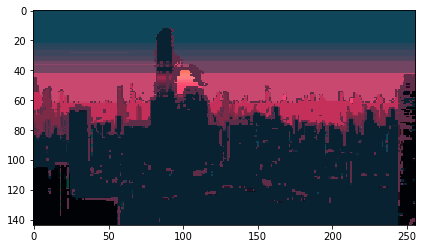

In [10]:
from sklearn.cluster import KMeans, SpectralClustering

# Not showing as great results as KMeans or SC but the clustering vis below is cool
clustered_image, cluster_colours = cluster_image_colours(tst_image, cluster_model=DBSCAN, eps=0.0065)
io.imshow(clustered_image)

In [5]:
flatten_img = lambda img: img.reshape(img.shape[0] * img.shape[1], img.shape[2])

def plot_image_colours(image_or_list, flatten=True, cluster_center_list=[]):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # lambda for plotting
    plot_pixel = lambda _pixel, _ax: _ax.scatter(*_pixel[:3], color=tuple(_pixel), alpha=0.1)

    # so we can plot multiple images or just a single image
    if type(image_or_list) == list:
        for _image in image_or_list:
            if flatten:
                _image = flatten_img(_image)
            for pixel in _image:
                plot_pixel(pixel, ax)
    else:
        if flatten:
            image_or_list = flatten_img(image_or_list)
        for pixel in image_or_list:
            plot_pixel(pixel, ax)
    for cluster_center in cluster_center_list:
        ax.scatter(*cluster_center, color='r', marker='x', s=150)
    
    # label our axes
    ax.set_xlabel('red')
    ax.set_ylabel('green')
    ax.set_zlabel('blue')
    plt.show()

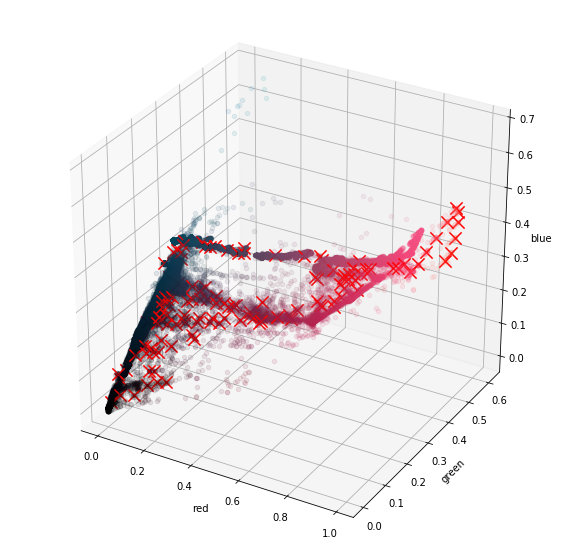

In [25]:
plot_image_colours(tst_image, cluster_colours)

# Clustering Video Frames

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


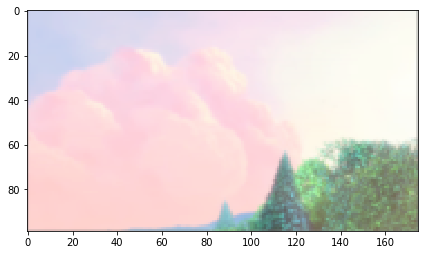

In [28]:
# for casting images to sk image format and rescaling
rescale_image = lambda _image, _amount=0.1: rescale(_image, _amount, anti_aliasing=True)
cast_frame = lambda _image: rescale_image(np.array([np.array(_pixel) for _pixel in _image]))

test_images = [] 
for i in range(1, 5):
    tst_i = io.imread('./test_images/BigBuckBunny/%d.png' % i)
    tst_i = rescale_image(tst_i)
    test_images.append(tst_i)

io.imshow(test_images[0])

In [38]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

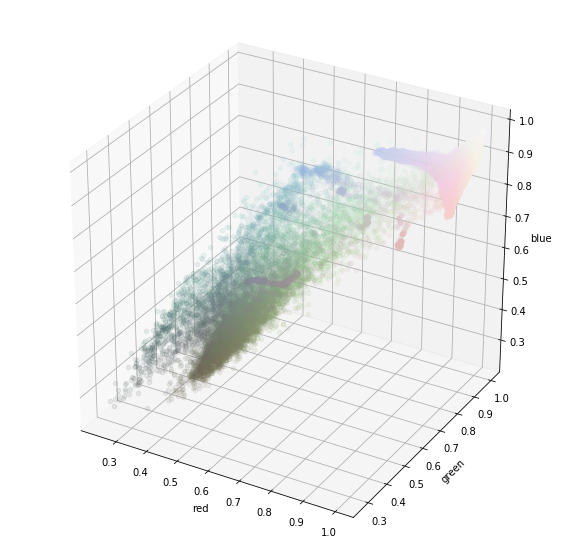

In [10]:
plot_image_colours(test_images[0])

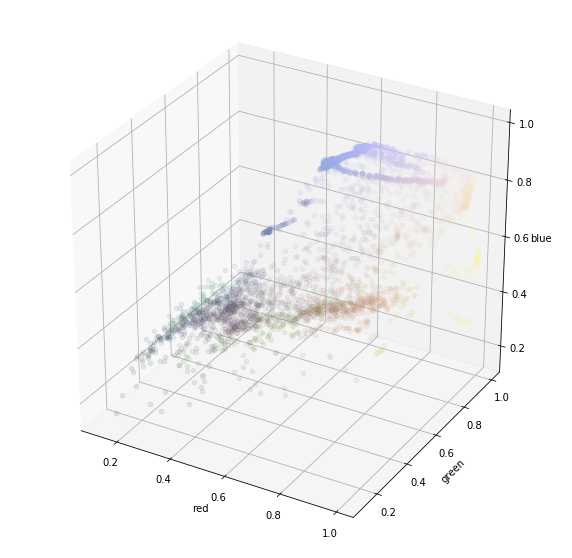

In [13]:
plot_image_colours(test_images[1])

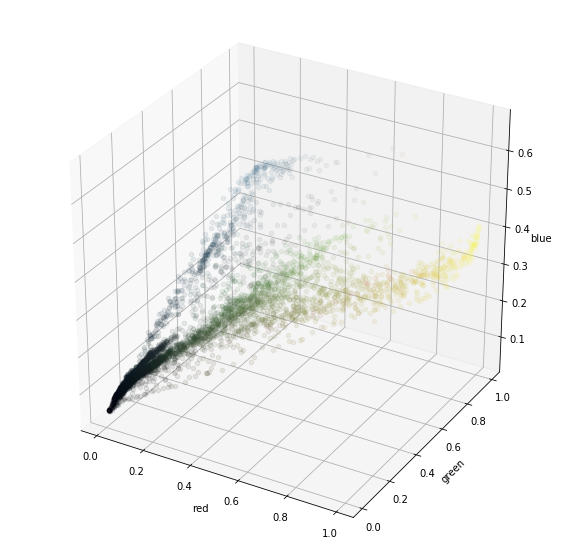

In [14]:
plot_image_colours(test_images[2])

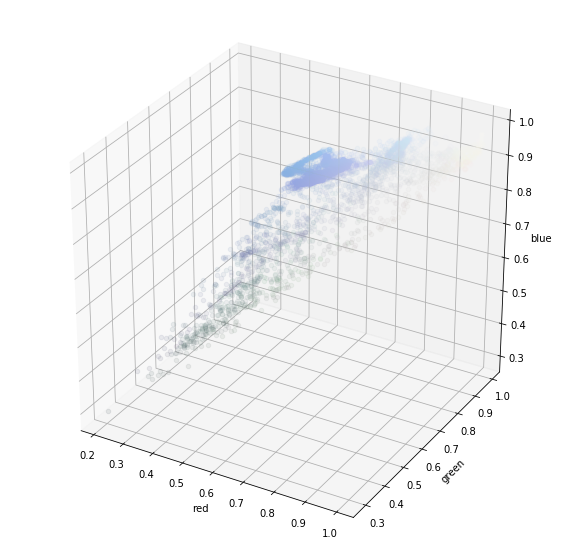

In [15]:
plot_image_colours(test_images[3])

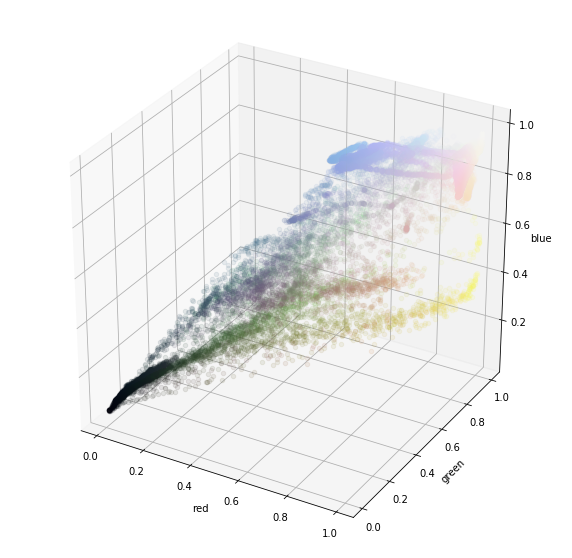

In [12]:
plot_image_colours(test_images)

In [39]:
import cv2

def get_x_test_frames(vid_name='./test_videos/BigBuckBunny.mp4', num_frames=5000, num_clusters=5):
    # should check it exists

    train_vid = cv2.VideoCapture(vid_name)

    # for storing our clustered data
    x_dat_arr = []
    count = 0

    # read in a frame
    success, image = train_vid.read()
    while success:
        if count >= num_frames:
            break
        image = cast_frame(image)
        image_clustered, colours = cluster_image_colours(image, cluster_model=KMeans, n_clusters=num_clusters)
        # this allows us to use this data later for clustering frames
        # i.e. an all black frame will only be able to find one cluster
        # we need consistent shape for kmeans
        if len(colours) == num_clusters:
            x_dat_arr.append(np.array(sorted(colours, key=lambda x: x[0])))
        success, image = train_vid.read()
        count += 1
        print('%d/%d' % (count, num_frames), sep='\r')
    return np.array(x_dat_arr)

1/5
2/5
3/5
4/5
5/5


In [4]:
big_buck_5000 = np.load('./test_videos/first_5000_frames.npy', allow_pickle=True) # get_x_test_frames()

In [37]:
# np.save('./test_videos/first_5000_frames.npy', big_buck_5000)

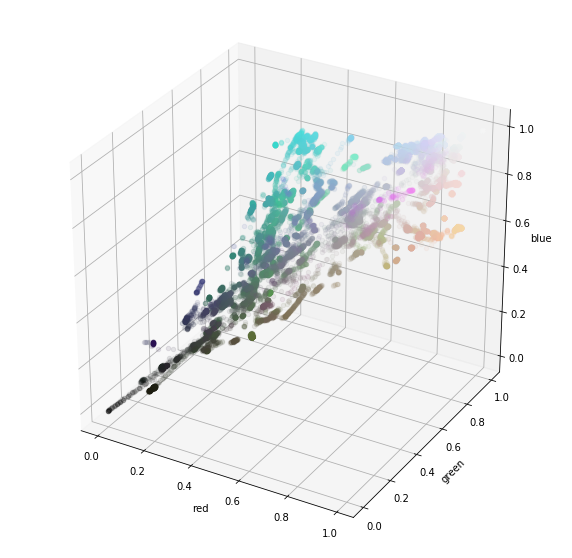

In [47]:
plot_image_colours(big_buck_5000, flatten=False)

In [17]:
# we still have some frames that only found 1 cluster, we need to filter these out so we can cluster
big_buck_5000 = np.array(filter(lambda x: len(x) == 5, big_buck_5000))

# need to figure out how to format the data for kmeans
# we're going from 5 colours represented in an array with r, g, b channels
# to having 15 features (5 * 3)
# which uncorrelates the colour aspect
big_buck_5000 = np.reshape(big_buck_5000, (big_buck_5000.shape[0], big_buck_5000.shape[1]*big_buck_5000.shape[2])

In [18]:
# see how many were filtered out
print(len(big_buck_5000))

4996


running model 0
running model 1
running model 2
running model 3
running model 4
running model 5
running model 6
running model 7
running model 8
running model 9
running model 10
running model 11
running model 12
running model 13
running model 14
running model 15
running model 16
running model 17
running model 18
running model 19
running model 20
running model 21
running model 22
running model 23
running model 24
running model 25
running model 26
running model 27
running model 28
running model 29
running model 30
running model 31
running model 32
running model 33
running model 34
running model 35
running model 36
running model 37


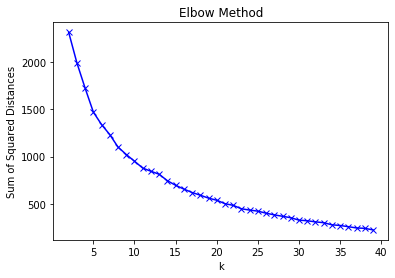

In [27]:
def detect_optimal_clusters(x_data, k_from=2, k_to=18):
    sum_of_sqrd_distances = []
    k_range = range(k_from, k_to)
    for idx, k in enumerate(k_range):
        print('running model %d' % idx)
        km = KMeans(n_clusters=k)
        km = km.fit(x_data)
        sum_of_sqrd_distances.append(km.inertia_)
    plt.plot(k_range, sum_of_sqrd_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method')
    plt.show()

detect_optimal_clusters(big_buck_5000, k_to=40)

In [24]:
big_buck_5000 = np.array(big_buck_5000)
big_buck_5000 = np.reshape(big_buck_5000, (4996, 15))